In [1]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 기본 라이브러리
import polars as pl
import pandas as pd
import seaborn as sns

# 시각화용 색상 팔레트
color_palette = sns.color_palette("Set2", as_cmap=False)

In [4]:
상품집계_고객집계_클러스터링전 = pl.read_csv('../data/상품집계_고객집계_클러스터링전.csv')

In [5]:
상품집계_고객집계_클러스터링전.head()

고객ID,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_총점수,거래기간(개월),연령대,최대_보유상품종류,평균_보유상품종류,최대_고객등급
i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,str
7449820487,0.0,0.0,0.0,0.0,0.0,70.282527,36,50,0,0,"""일반등급"""
6406534297,5.4733e6,3.15e7,0.0,61000.0,0.0,1602.815556,36,50,3,2,"""일반등급"""
6298470811,1.0613e6,2.6419e6,0.0,322.580645,1.2226e6,882.57164,36,30,3,2,"""일반등급"""
5619863903,545161.290323,9.4323e6,0.0,0.0,0.0,381.741935,36,50,3,1,"""일반등급"""
7674680602,6.5839e6,0.0,0.0,0.0,0.0,517.462366,36,60,1,1,"""일반등급"""


In [6]:
clustering_origin = 상품집계_고객집계_클러스터링전[['고객ID', '연령대', '평균_입출금예금', '평균_기타예금', '평균_비이자상품', '평균_카드', '평균_대출', '평균_보유상품종류']].clone()

# 비지도학습 기반 분류 (평균_입출금예금, 평균_기타예금,	평균_비이자상품, 평균_카드,	평균_대출,	평균_보유상품종류, best k 찾기)

In [7]:
# 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
import pandas as pd

In [8]:
# 데이터 준비
df = clustering_origin.clone()
# Polars에서 수치형 컬럼만 추출
numeric_columns = [col for col, dtype in df.schema.items() if dtype in pl.NUMERIC_DTYPES]
exclude_cols = ["고객ID", "연령대"]  # 분석에서 제외할 컬럼
use_columns = [col for col in numeric_columns if col not in exclude_cols]

X = df.select(use_columns)
X_scaled = StandardScaler().fit_transform(X.to_numpy())

In [9]:
X

평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_보유상품종류
f64,f64,f64,f64,f64,i64
0.0,0.0,0.0,0.0,0.0,0
5.4733e6,3.15e7,0.0,61000.0,0.0,2
1.0613e6,2.6419e6,0.0,322.580645,1.2226e6,2
545161.290323,9.4323e6,0.0,0.0,0.0,1
6.5839e6,0.0,0.0,0.0,0.0,1
…,…,…,…,…,…
7.2806e6,0.0,0.0,34193.548387,0.0,2
54838.709677,0.0,0.0,104838.709677,0.0,1
22580.645161,261290.322581,0.0,68387.096774,0.0,0


In [10]:
X_scaled

array([[-0.44033389, -0.29234223, -0.07281139, -0.37714088, -0.25638575,
        -1.41784243],
       [ 0.34447353,  3.15458833, -0.07281139, -0.21428999, -0.25638575,
         0.60892361],
       [-0.28815815, -0.00324483, -0.07281139, -0.37627969, -0.13326319,
         0.60892361],
       ...,
       [-0.4370961 , -0.26375018, -0.07281139, -0.19456875, -0.25638575,
        -1.41784243],
       [-0.4367492 , -0.29234223, -0.07281139, -0.37714088, -0.15190213,
        -0.40445941],
       [-0.36956523, -0.29234223, -0.07281139, -0.37714088, -0.25638575,
        -0.40445941]])

## k means

In [11]:
results = []

# k값을 2부터 9까지 반복하며 클러스터 평가
for k in range(2, 10):
    # KMeans 클러스터링 모델 학습
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # silhouette score 계산 시 너무 느려지는 걸 방지하기 위해 1만 개만 샘플링
    X_sampled, labels_sampled = resample(
        X_scaled, labels,
        n_samples=min(10000, len(X_scaled)),
        random_state=42
    )

    # 세 가지 평가 지표 계산
    results.append({
        "k": k,
        "silhouette": silhouette_score(X_sampled, labels_sampled),          # 군집 간 분리 + 내부 응집
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),     # 분산 기반 평가
        "davies_bouldin": davies_bouldin_score(X_scaled, labels)            # 군집 간 거리 / 내부 거리 (낮을수록 좋음)
    })

# 리스트 → DataFrame 변환
result_kmeans = pd.DataFrame(results)

# 각 지표에 대해 순위 계산
# silhouette / ch는 클수록 좋으므로 내림차순(ascending=False)
# db는 작을수록 좋으므로 오름차순(ascending=True)
result_kmeans["rank_silhouette"] = result_kmeans["silhouette"].rank(ascending=False)
result_kmeans["rank_ch"] = result_kmeans["calinski_harabasz"].rank(ascending=False)
result_kmeans["rank_db"] = result_kmeans["davies_bouldin"].rank(ascending=True)

# 평균 순위 계산 → 종합 평가 지표로 활용
result_kmeans["rank_avg"] = result_kmeans[["rank_silhouette", "rank_ch", "rank_db"]].mean(axis=1)

In [12]:
result_kmeans

,k,silhouette,calinski_harabasz,davies_bouldin,rank_silhouette,rank_ch,rank_db,rank_avg
0,2,0.559415,514726.054613,1.527289,2.0,7.0,8.0,5.666667
1,3,0.568792,476101.416800,1.296921,1.0,8.0,7.0,5.333333
2,4,0.554855,516498.271781,1.081207,3.0,6.0,6.0,5.000000
3,5,0.507387,565422.508235,1.004597,4.0,5.0,4.0,4.333333
4,6,0.484633,595906.239627,0.919249,5.0,2.0,2.0,3.000000
5,7,0.387195,576945.222119,0.883266,8.0,4.0,1.0,4.333333
6,8,0.459225,607803.617802,0.947096,6.0,1.0,3.0,3.333333
7,9,0.435511,578630.706040,1.065687,7.0,3.0,5.0,5.000000


## gmm

In [13]:
# results = []

# # k값을 2부터 9까지 반복하며 GMM 클러스터 평가
# for k in range(2, 10):
#     # GMM 클러스터링 모델 학습
#     gmm = GaussianMixture(n_components=k, random_state=42)
#     labels = gmm.fit_predict(X_scaled)

#     # silhouette score 계산 시 너무 느려지는 걸 방지하기 위해 1만 개만 샘플링
#     X_sampled, labels_sampled = resample(
#         X_scaled, labels,
#         n_samples=min(10000, len(X_scaled)),
#         random_state=42
#     )

#     # 세 가지 평가 지표 계산
#     results.append({
#         "k": k,
#         "silhouette": silhouette_score(X_sampled, labels_sampled),          # 군집 간 분리 + 내부 응집
#         "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),     # 분산 기반 평가
#         "davies_bouldin": davies_bouldin_score(X_scaled, labels)            # 군집 간 거리 / 내부 거리 (낮을수록 좋음)
#     })

# # 리스트 → DataFrame 변환
# result_gmm = pd.DataFrame(results)

# # 각 지표에 대해 순위 계산
# # silhouette / ch는 클수록 좋으므로 내림차순(ascending=False)
# # db는 작을수록 좋으므로 오름차순(ascending=True)
# result_gmm["rank_silhouette"] = result_gmm["silhouette"].rank(ascending=False)
# result_gmm["rank_ch"] = result_gmm["calinski_harabasz"].rank(ascending=False)
# result_gmm["rank_db"] = result_gmm["davies_bouldin"].rank(ascending=True)

# # 평균 순위 계산 → 종합 평가 지표로 활용
# result_gmm["rank_avg"] = result_gmm[["rank_silhouette", "rank_ch", "rank_db"]].mean(axis=1)

# # 평균 순위가 가장 낮은(즉, 전체적으로 가장 높은 평가를 받은) k를 Best k로 선정
# best_k_rank_gmm = result_gmm.loc[result_gmm["rank_avg"].idxmin(), "k"]

## k means vs gmm
- 999_003_분석_1_clustering_총점수_전체_0314.ipynb 참고

In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 비교할 지표 리스트
# metrics = ["silhouette", "calinski_harabasz", "davies_bouldin"]

# # 서브플롯 준비 (1행 3열)
# fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# # 지표별로 subplot에 추가
# for i, metric in enumerate(metrics):
#     ax = axes[i]
    
#     # KMeans 점수 라인
#     sns.lineplot(data=result_kmeans, x="k", y=metric, marker="o", label="KMeans", ax=ax, color="mediumaquamarine")
    
#     # GMM 점수 라인
#     sns.lineplot(data=result_gmm, x="k", y=metric, marker="s", label="GMM", ax=ax, color="seagreen")
    
#     # 그래프 꾸미기
#     ax.set_title(f"{metric} 점수 비교", fontsize=13)
#     ax.set_xlabel("k (클러스터 수)")
#     ax.set_ylabel(metric)
#     ax.grid(True, linestyle='--', alpha=0.5)
#     ax.legend()

# plt.suptitle("KMeans vs GMM 클러스터링 평가 지표 비교", fontsize=16, y=1.05)
# plt.tight_layout()
# plt.show()


## 최적 K 정하기

In [15]:
# elbow point 자동 탐지 코드로 최적 k 찾아보기

In [16]:
!pip install kneed


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### k means

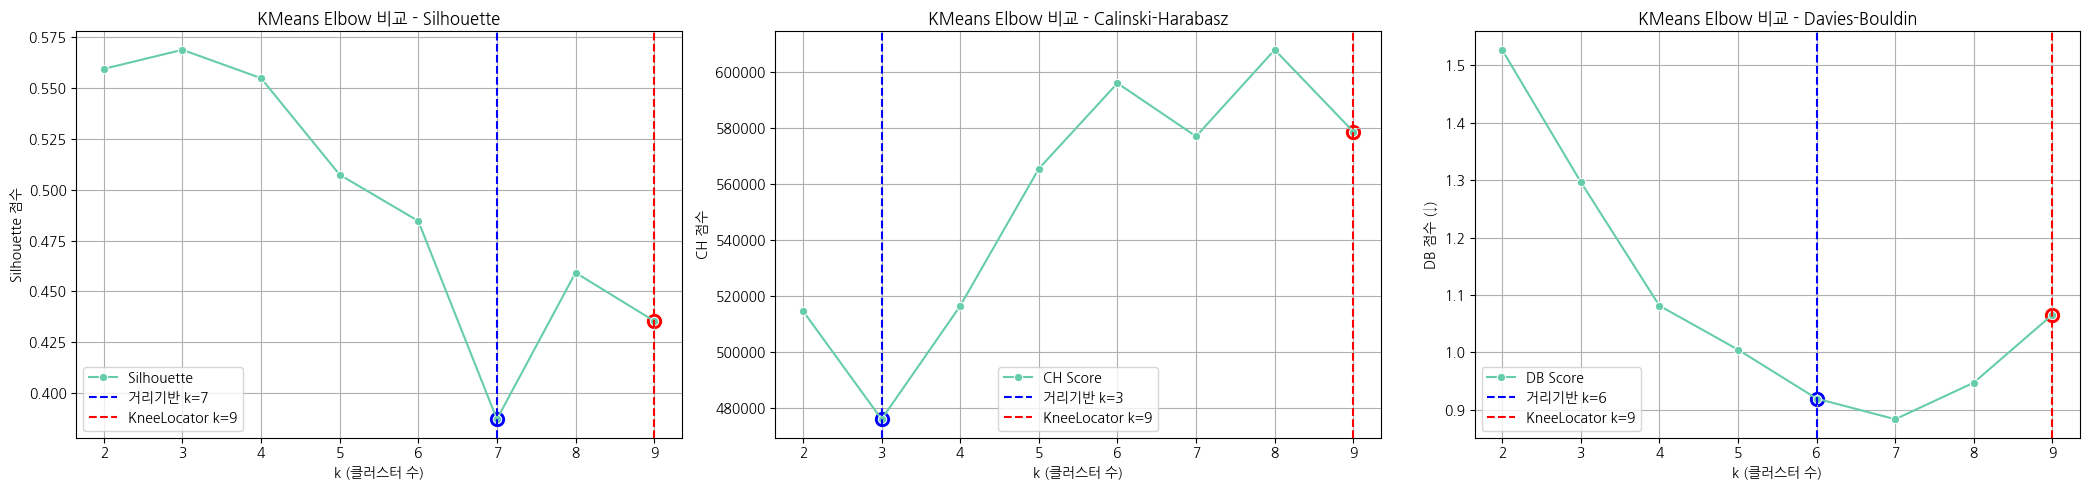

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kneed import KneeLocator

# ✅ 거리기반 elbow 계산 함수
def find_elbow_point(df, score_col):
    x = df["k"].to_numpy()
    y = df[score_col].to_numpy()
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])
    distances = []
    for i in range(len(x)):
        point = np.array([x[i], y[i]])
        vec_line = end - start
        vec_point = point - start
        proj_len = np.dot(vec_line, vec_point) / np.linalg.norm(vec_line)
        proj_point = start + proj_len * vec_line / np.linalg.norm(vec_line)
        dist = np.linalg.norm(point - proj_point)
        distances.append(dist)
    best_idx = int(np.argmax(distances))
    return int(x[best_idx])

# ✅ KneeLocator 방식
def find_elbow_kneedf(df, metric, direction="increasing"):
    x = df["k"].to_list()
    y = df[metric].to_list()
    curve_type = "convex" if direction == "increasing" else "concave"
    kneedle = KneeLocator(x, y, curve=curve_type, direction=direction)
    return kneedle.knee

# ✅ 개별 지표 처리 ------------------------------

# Silhouette
df_sil = result_kmeans[["k", "silhouette"]].copy()
elbow_kmeans_dist_sil = find_elbow_point(df_sil, "silhouette")
elbow_kmeans_knee_sil = find_elbow_kneedf(df_sil, "silhouette", direction="increasing")
score_dist_sil = df_sil[df_sil["k"] == elbow_kmeans_dist_sil]["silhouette"].values[0]
score_knee_sil = df_sil[df_sil["k"] == elbow_kmeans_knee_sil]["silhouette"].values[0]

# CH
df_ch = result_kmeans[["k", "calinski_harabasz"]].copy()
elbow_kmeans_distance_ch = find_elbow_point(df_ch, "calinski_harabasz")
elbow_kmeans_knee_ch = find_elbow_kneedf(df_ch, "calinski_harabasz", direction="increasing")
score_dist_ch = df_ch[df_ch["k"] == elbow_kmeans_distance_ch]["calinski_harabasz"].values[0]
score_knee_ch = df_ch[df_ch["k"] == elbow_kmeans_knee_ch]["calinski_harabasz"].values[0]

# DB
df_db = result_kmeans[["k", "davies_bouldin"]].copy()
elbow_kmeans_distance_db = find_elbow_point(df_db, "davies_bouldin")
elbow_kmeans_knee_db = find_elbow_kneedf(df_db, "davies_bouldin", direction="decreasing")
score_dist_db = df_db[df_db["k"] == elbow_kmeans_distance_db]["davies_bouldin"].values[0]
score_knee_db = df_db[df_db["k"] == elbow_kmeans_knee_db]["davies_bouldin"].values[0]

# ✅ 시각화 ------------------------------

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# --- Silhouette
sns.lineplot(data=df_sil, x="k", y="silhouette", ax=axes[0], color="mediumaquamarine", marker="o", label="Silhouette")
axes[0].axvline(x=elbow_kmeans_dist_sil, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_dist_sil}")
axes[0].scatter(elbow_kmeans_dist_sil, score_dist_sil, color="blue", s=100)
axes[0].axvline(x=elbow_kmeans_knee_sil, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_sil}")
axes[0].scatter(elbow_kmeans_knee_sil, score_knee_sil, color="red", s=100)
axes[0].set_title("KMeans Elbow 비교 - Silhouette")
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].legend()
axes[0].grid(True)

# --- CH
sns.lineplot(data=df_ch, x="k", y="calinski_harabasz", ax=axes[1], color="mediumaquamarine", marker="o", label="CH Score")
axes[1].axvline(x=elbow_kmeans_distance_ch, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_distance_ch}")
axes[1].scatter(elbow_kmeans_distance_ch, score_dist_ch, color="blue", s=100)
axes[1].axvline(x=elbow_kmeans_knee_ch, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_ch}")
axes[1].scatter(elbow_kmeans_knee_ch, score_knee_ch, color="red", s=100)
axes[1].set_title("KMeans Elbow 비교 - Calinski-Harabasz")
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].legend()
axes[1].grid(True)

# --- DB
sns.lineplot(data=df_db, x="k", y="davies_bouldin", ax=axes[2], color="mediumaquamarine", marker="o", label="DB Score")
axes[2].axvline(x=elbow_kmeans_distance_db, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_distance_db}")
axes[2].scatter(elbow_kmeans_distance_db, score_dist_db, color="blue", s=100)
axes[2].axvline(x=elbow_kmeans_knee_db, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_db}")
axes[2].scatter(elbow_kmeans_knee_db, score_knee_db, color="red", s=100)
axes[2].set_title("KMeans Elbow 비교 - Davies-Bouldin")
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


# 라벨링 후 내보내기

In [18]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import time
import polars as pl

def add_clustering_label(df: pl.DataFrame, label_name: str, k: int, X):
    """KMeans 또는 GMM 클러스터링 라벨을 df에 추가하고 소요시간 출력"""
    print(f"▶ 실행 중: {label_name} (k={k})")
    start = time.time()

    # 모델 선택 및 학습
    if label_name.startswith("KMeans"):
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
    elif label_name.startswith("GMM"):
        model = GaussianMixture(n_components=k, random_state=42)
        labels = model.fit_predict(X)
    else:
        raise ValueError(f"Unknown model type in label: {label_name}")

    # ✅ Polars에서는 with_columns로 라벨 추가해야 함
    df = df.with_columns(pl.Series(label_name, labels))

    end = time.time()
    print(f"✅ 완료: {label_name} | 소요시간: {end - start:.2f}초\n")
    return df

In [19]:
k_values = {
    #"KMeans_실루엣_거리기반": elbow_kmeans_distance_sil,
    #"KMeans_실루엣_KneeLocator": elbow_kmeans_knee_sil,
    #"KMeans_CH_거리기반": elbow_kmeans_distance_ch,
    #"KMeans_CH_KneeLocator": elbow_kmeans_knee_ch,
    #"KMeans_DB_거리기반": elbow_kmeans_distance_db,
    "KMeans_DB_KneeLocator": elbow_kmeans_knee_db,
    # "GMM_실루엣_거리기반": elbow_k_distance_gmm_sil,
    # "GMM_실루엣_KneeLocator": elbow_k_knee_gmm_sil,
    # "GMM_CH_거리기반": elbow_k_distance_gmm_ch,
    # "GMM_CH_KneeLocator": elbow_k_knee_gmm_ch,
    # "GMM_DB_거리기반": elbow_k_distance_gmm_db,
    # "GMM_DB_KneeLocator": elbow_k_knee_gmm_db,
}


In [20]:
for label, k in k_values.items():
    df = clustering_origin.clone()
    df = add_clustering_label(df, label, k, X)
    # df.write_parquet("중간저장.parquet") 등도 가능

▶ 실행 중: KMeans_DB_KneeLocator (k=9)
✅ 완료: KMeans_DB_KneeLocator | 소요시간: 1.68초



In [21]:
df['KMeans_DB_KneeLocator'].value_counts()

KMeans_DB_KneeLocator,count
i32,u32
2,12237
7,12810
8,41067
3,49833
5,193233
4,79124
0,1467165
6,85803
1,37421


In [23]:
df

고객ID,연령대,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_보유상품종류,KMeans_DB_KneeLocator
i64,i64,f64,f64,f64,f64,f64,i64,i32
7449820487,50,0.0,0.0,0.0,0.0,0.0,0,0
6406534297,50,5.4733e6,3.15e7,0.0,61000.0,0.0,2,8
6298470811,30,1.0613e6,2.6419e6,0.0,322.580645,1.2226e6,2,0
5619863903,50,545161.290323,9.4323e6,0.0,0.0,0.0,1,6
7674680602,60,6.5839e6,0.0,0.0,0.0,0.0,1,5
…,…,…,…,…,…,…,…,…
7077812224,60,7.2806e6,0.0,0.0,34193.548387,0.0,2,5
7581972066,30,54838.709677,0.0,0.0,104838.709677,0.0,1,0
3006474349,20,22580.645161,261290.322581,0.0,68387.096774,0.0,0,0


In [25]:
df_pls_be_collect = df.filter([
    (pl.col('연령대') == 20) |
    (pl.col('연령대') == 30)
])

In [31]:
tt = df_pls_be_collect.select(
    pl.col("KMeans_DB_KneeLocator")
).to_pandas().value_counts()

In [41]:
tt = pd.DataFrame(tt).reset_index()

<Axes: xlabel='KMeans_DB_KneeLocator', ylabel='count'>

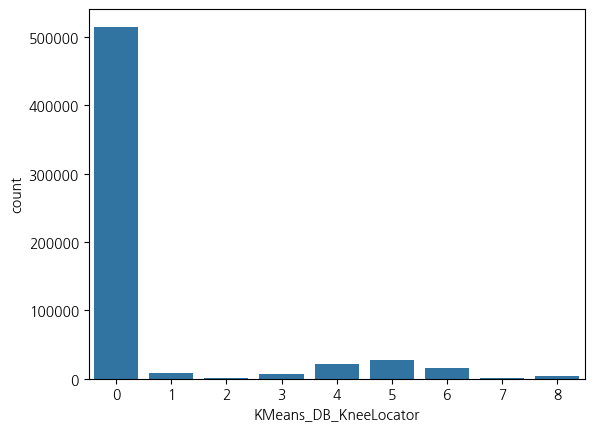

In [45]:
sns.barplot(x = tt['KMeans_DB_KneeLocator'], y = tt['count'])

In [22]:
#df.write_csv('./dataset/상품집계_고객집계.csv')